<a href="https://colab.research.google.com/github/magourram/information_retrieval/blob/main/info_ret_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries

In [1]:
import tensorflow as tf
print("GPU Available: ", tf.test.gpu_device_name())

# If GPU is available, set the runtime to GPU
if tf.test.gpu_device_name():
    print("Using GPU")
else:
    print("GPU not found. Switching to CPU.")

GPU Available:  /device:GPU:0
Using GPU


In [2]:
import os
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import zipfile
from zipfile import ZipFile
import shutil
import matplotlib.image as mpimg
from matplotlib.ticker import MaxNLocator
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Flatten, Dense

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
start_time = time.time()

# Functions

In [5]:
# Function to extract images from a zipped file
def extract_images(zip_file_path, extraction_path):
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

In [6]:
# Function to return the first image
def get_sample_image(category_data):
    return category_data[0]

In [7]:
# Function to rename a subfolder
def rename_subfolder(parent_folder, old_name, new_name):
    # Construct the full paths for the old and new subfolders
    old_path = os.path.join(parent_folder, old_name)
    new_path = os.path.join(parent_folder, new_name)

    try:
        # Rename the subfolder
        os.rename(old_path, new_path)
        print(f"Subfolder '{old_name}' renamed to '{new_name}'")
    except FileNotFoundError:
        print(f"Error: Subfolder '{old_name}' not found in '{parent_folder}'")
    except FileExistsError:
        print(f"Error: Subfolder '{new_name}' already exists in '{parent_folder}'")

In [8]:
# Function to remove folders
def remove_folder(folder_path):
    try:
        # Remove the folder and its contents
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' removed successfully.")
    except FileNotFoundError:
        print(f"Error: Folder '{folder_path}' not found.")
    except OSError as e:
        print(f"Error: {e}")

In [9]:
# Function to plot images
def plot_images_from_folder(folder, num_cols=3):
    # Get a list of subfolders in the train folder
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]

    # Calculate number of rows required
    num_rows = (len(subfolders) + num_cols - 1) // num_cols

    # Set up the subplot grid
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

    # Flatten the axes array to make it easier to iterate
    axes = axes.flatten()

    # Plot one image from each subfolder
    for i, subfolder in enumerate(subfolders):
        # Get the list of images in the subfolder
        images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Plot the first image in the subfolder
        if images:
            img_path = images[0]
            img = mpimg.imread(img_path)

            # Extract subfolder name from the path for the plot title
            subfolder_name = os.path.basename(subfolder)

            # Plot the image
            axes[i].imshow(img)
            axes[i].set_title(subfolder_name)
            axes[i].axis('off')  # Turn off axis labels

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

In [10]:
# Function to preprocess images
def preprocess_image(image, label):
    # Resize and reshape the image to the desired dimensions
    image = tf.image.resize_with_pad(image, 150, 150)
    # Perform any additional preprocessing if needed
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

In [11]:
# Function to extract images
def extract_all_zips(input_folder, output_folder):
    # List all files in the input folder
    files = os.listdir(input_folder)

    # Iterate through each file
    for file in files:
        # Check if the file is a zip file
        if file.endswith(".zip"):
            # Construct the full path to the zip file
            zip_file_path = os.path.join(input_folder, file)

            # Create a ZipFile object and extract all contents to the output folder
            with ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(output_folder)

            print(f"Extracted {file} to {output_folder}")

In [12]:
def count_images_in_subfolders(folder_path):
    # Get a list of subfolders in the specified folder
    subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

    # Iterate through each subfolder and count the number of images
    for subfolder in subfolders:
        # Get a list of all files in the subfolder
        files = [f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))]

        # Filter only image files (you can customize the extensions if needed)
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

        # Print the subfolder name and the number of images
        print(f"Subfolder '{os.path.basename(subfolder)}' has {len(image_files)} images.")

In [13]:
# Function to perform on the file
def resize_images(category_names, folder_path, size):
    images, labels = [], []

    for category in category_names:
        file_location = os.path.join(folder_path, category)

        if os.path.exists(file_location):
            print(f"Listing files in directory for category {category}.")

            counter = 0

            for img in os.listdir(file_location):
                if counter < size:
                    img_path = os.path.join(file_location, img)

                    try:
                        with Image.open(img_path).convert("RGB").resize((120, 120)) as img_open:
                            img_array = tf.keras.preprocessing.image.img_to_array(img_open)
                            images.append(img_array)
                            labels.append(category_names.index(category))

                        counter += 1
                    except Exception as e:
                        print(f"Warning: Skipped a corrupted image in category {category}. Error: {e}")

                else:
                    break

    print("Processing complete.")
    return images, labels

In [14]:
# Function to compare the category names across train and test set
def compare_categories(train_folder_extraction, test_folder_extraction):
  # Get the set of subfolder names in the "train" directory
  train_categories = {category for category in os.listdir(train_folder_extraction) if os.path.isdir(os.path.join(train_folder_extraction, category))}

  # Get the set of subfolder names in the "test" directory
  test_categories = {category for category in os.listdir(test_folder_extraction) if os.path.isdir(os.path.join(test_folder_extraction, category))}

  # Check if the sets of category names are the same in both "train" and "test" folders
  if train_categories == test_categories:
    print("Category names are the same in both 'train' and 'test' folders.")
    category_names = list(train_categories)  # Convert set to list if needed
    print("Category names:", category_names)
  else:
    # Identify the differences
    train_not_in_test = train_categories - test_categories
    test_not_in_train = test_categories - train_categories

    # Print the results
    if train_not_in_test:
      print(f"Categories in 'train' but not in 'test': {list(train_not_in_test)}")
    if test_not_in_train:
      print(f"Categories in 'test' but not in 'train': {list(test_not_in_train)}")

    return category_names

# Setup

In [15]:
# Path to the folders containing zipped files
train_folder_path = '/content/drive/MyDrive/Colab Notebooks/Image_Event/Train'
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/Image_Event/Test'
soccer_folder_path = '/content/drive/MyDrive/Colab Notebooks/Image_Event'
event_folder_path = '/content/drive/MyDrive/Colab Notebooks/Image_Event'

train_folder_extraction = '/content/train_extracted'
test_folder_extraction = '/content/test_extracted'
soccer_folder_extraction = '/content/soccer_extracted'
event_folder_extraction = '/content/event_extracted'

category_names = ["Cards", "Center", "Corner", "Free-Kick", "Left", "Penalty", "Red-Cards", "Right", "Tackle", "To-Subtitue", "Yellow-Cards"]

In [16]:
# Replace 'your_input_folder' and 'your_output_folder' with the actual paths
print("---Extracting train---")
extract_all_zips(train_folder_path, train_folder_extraction)
print("Process completed")
print("---Extracting test---")
extract_all_zips(test_folder_path, test_folder_extraction)
print("Process completed")

---Extracting train---
Extracted Yellow-Cards.zip to /content/train_extracted
Extracted Center.zip to /content/train_extracted
Extracted Corner.zip to /content/train_extracted
Extracted Free-Kick.zip to /content/train_extracted
Extracted Left.zip to /content/train_extracted
Extracted Penalty.zip to /content/train_extracted
Extracted Red-Cards.zip to /content/train_extracted
Extracted Right.zip to /content/train_extracted
Extracted Tackle.zip to /content/train_extracted
Extracted To-Subtitue.zip to /content/train_extracted
Extracted Cards.zip to /content/train_extracted
Process completed
---Extracting test---
Extracted Center.zip to /content/test_extracted
Extracted Free-Kick.zip to /content/test_extracted
Extracted Left.zip to /content/test_extracted
Extracted Penalty.zip to /content/test_extracted
Extracted Red-Cards.zip to /content/test_extracted
Extracted Right.zip to /content/test_extracted
Extracted Tackle.zip to /content/test_extracted
Extracted To-Subtitue.zip to /content/test_e

In [17]:
# Rename 'to-substitute'
rename_subfolder(train_folder_extraction, 'To Subtitue', 'To-Subtitue')

Subfolder 'To Subtitue' renamed to 'To-Subtitue'


In [18]:
# Count images in each train subfolder
count_images_in_subfolders(train_folder_extraction)

Subfolder 'Red-Cards' has 5500 images.
Subfolder 'Right' has 5500 images.
Subfolder 'Corner' has 5500 images.
Subfolder 'To-Subtitue' has 5500 images.
Subfolder 'Free-Kick' has 5500 images.
Subfolder 'Left' has 5500 images.
Subfolder 'Penalty' has 5500 images.
Subfolder 'Tackle' has 5500 images.
Subfolder 'Yellow-Cards' has 5500 images.
Subfolder 'Center' has 5500 images.
Subfolder 'Cards' has 5500 images.


In [19]:
# Count images in each test subfolder
count_images_in_subfolders(test_folder_extraction)

Subfolder 'Red-Cards' has 500 images.
Subfolder 'Right' has 500 images.
Subfolder 'Corner' has 500 images.
Subfolder 'To-Subtitue' has 500 images.
Subfolder 'Free-Kick' has 500 images.
Subfolder 'Left' has 500 images.
Subfolder 'Penalty' has 500 images.
Subfolder 'Tackle' has 500 images.
Subfolder 'Yellow-Cards' has 500 images.
Subfolder 'Center' has 500 images.
Subfolder 'Cards' has 500 images.


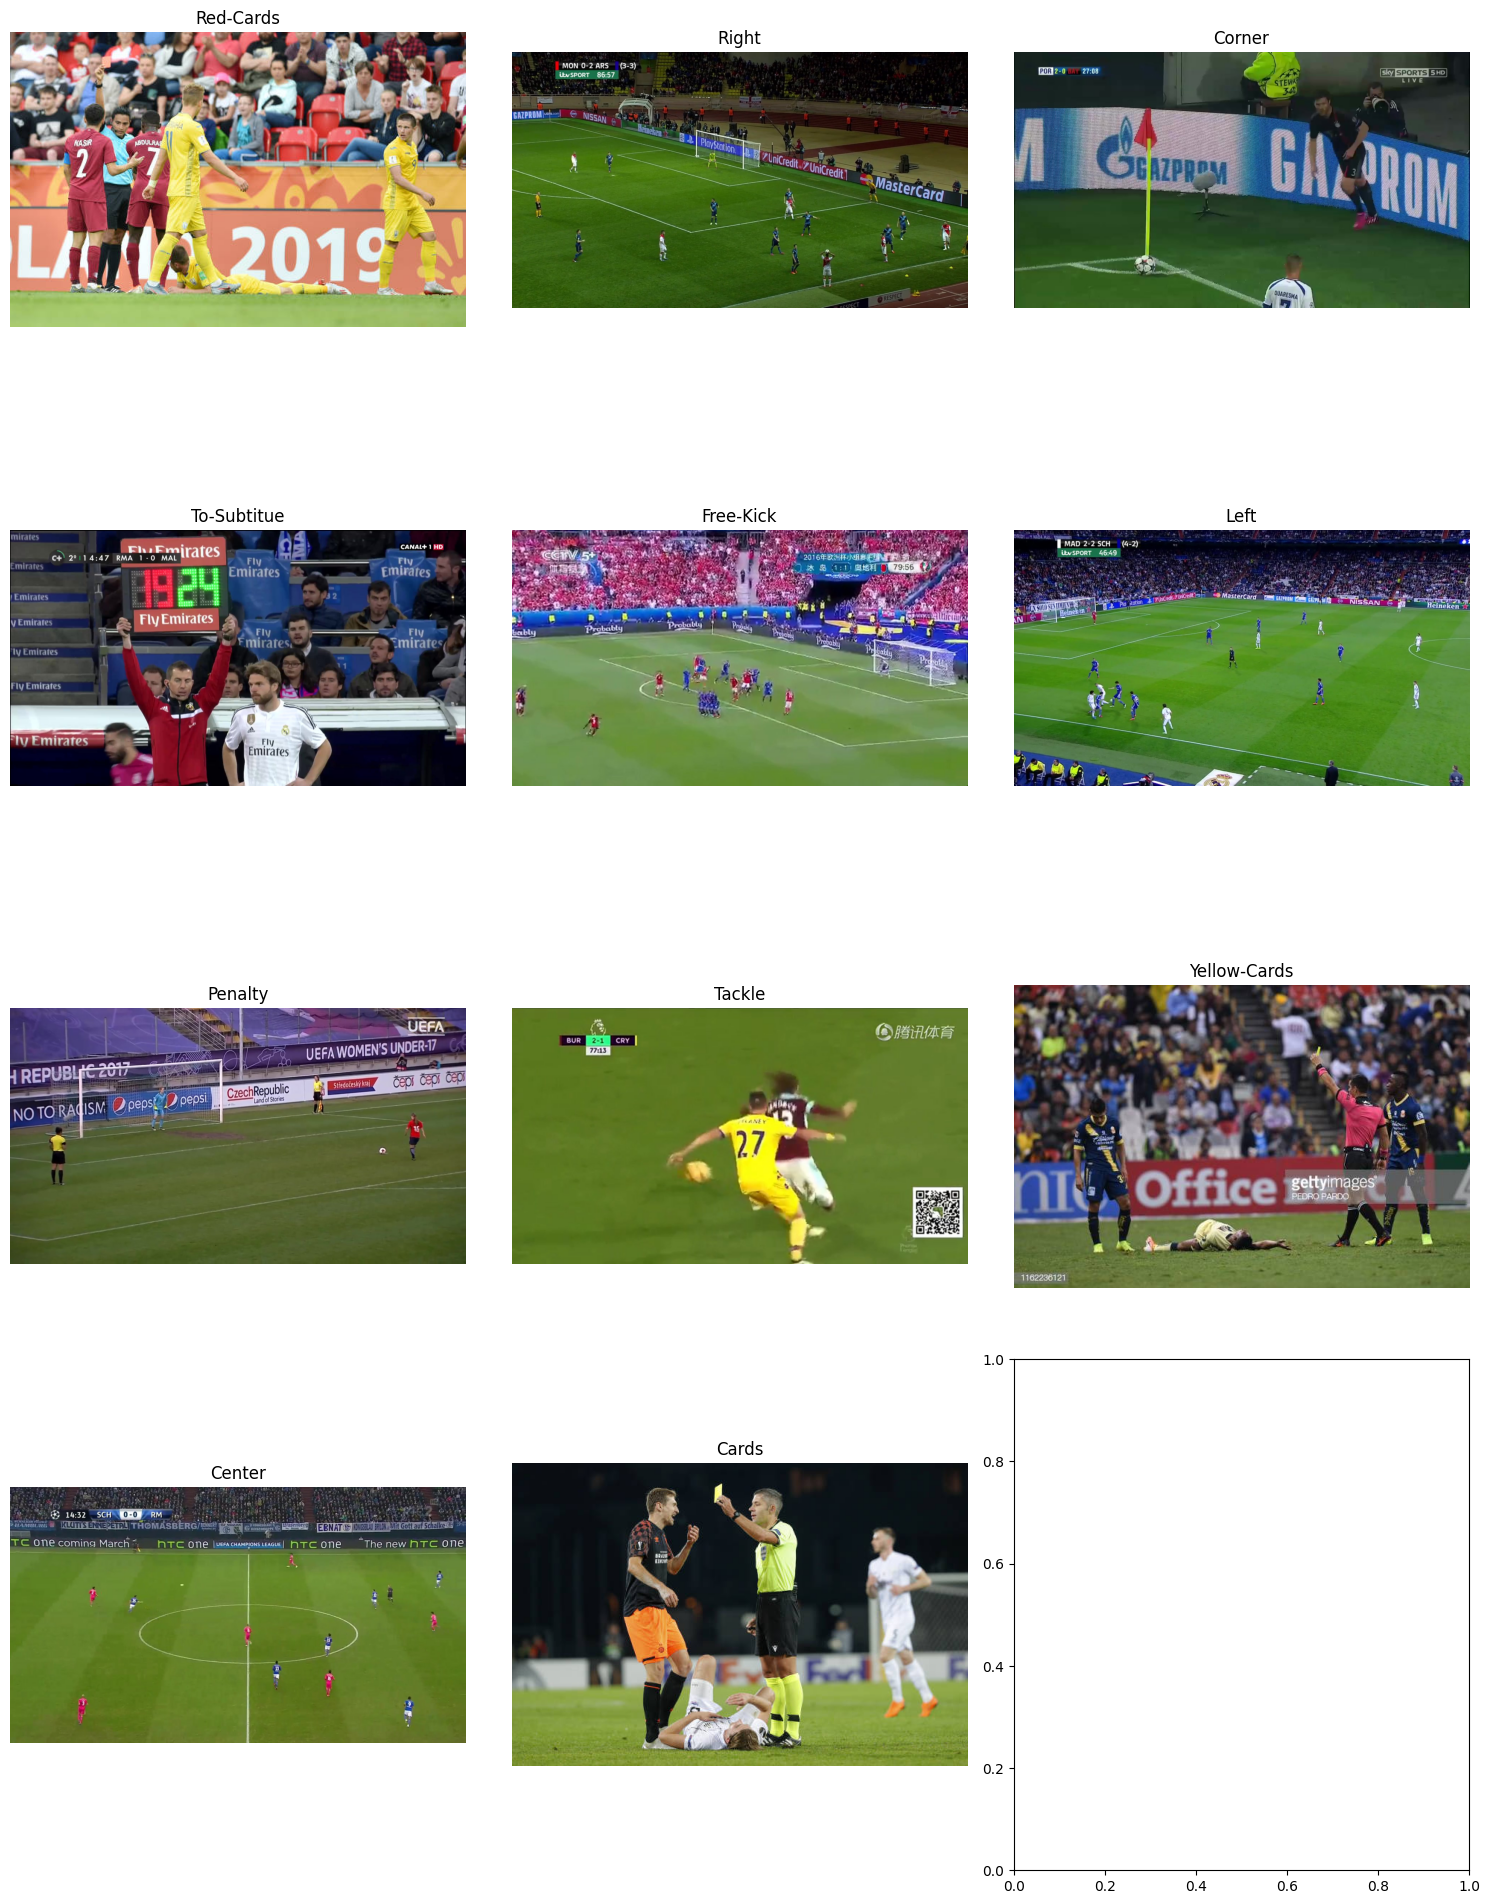

In [20]:
# Plot images from train folder
plot_images_from_folder(train_folder_extraction)

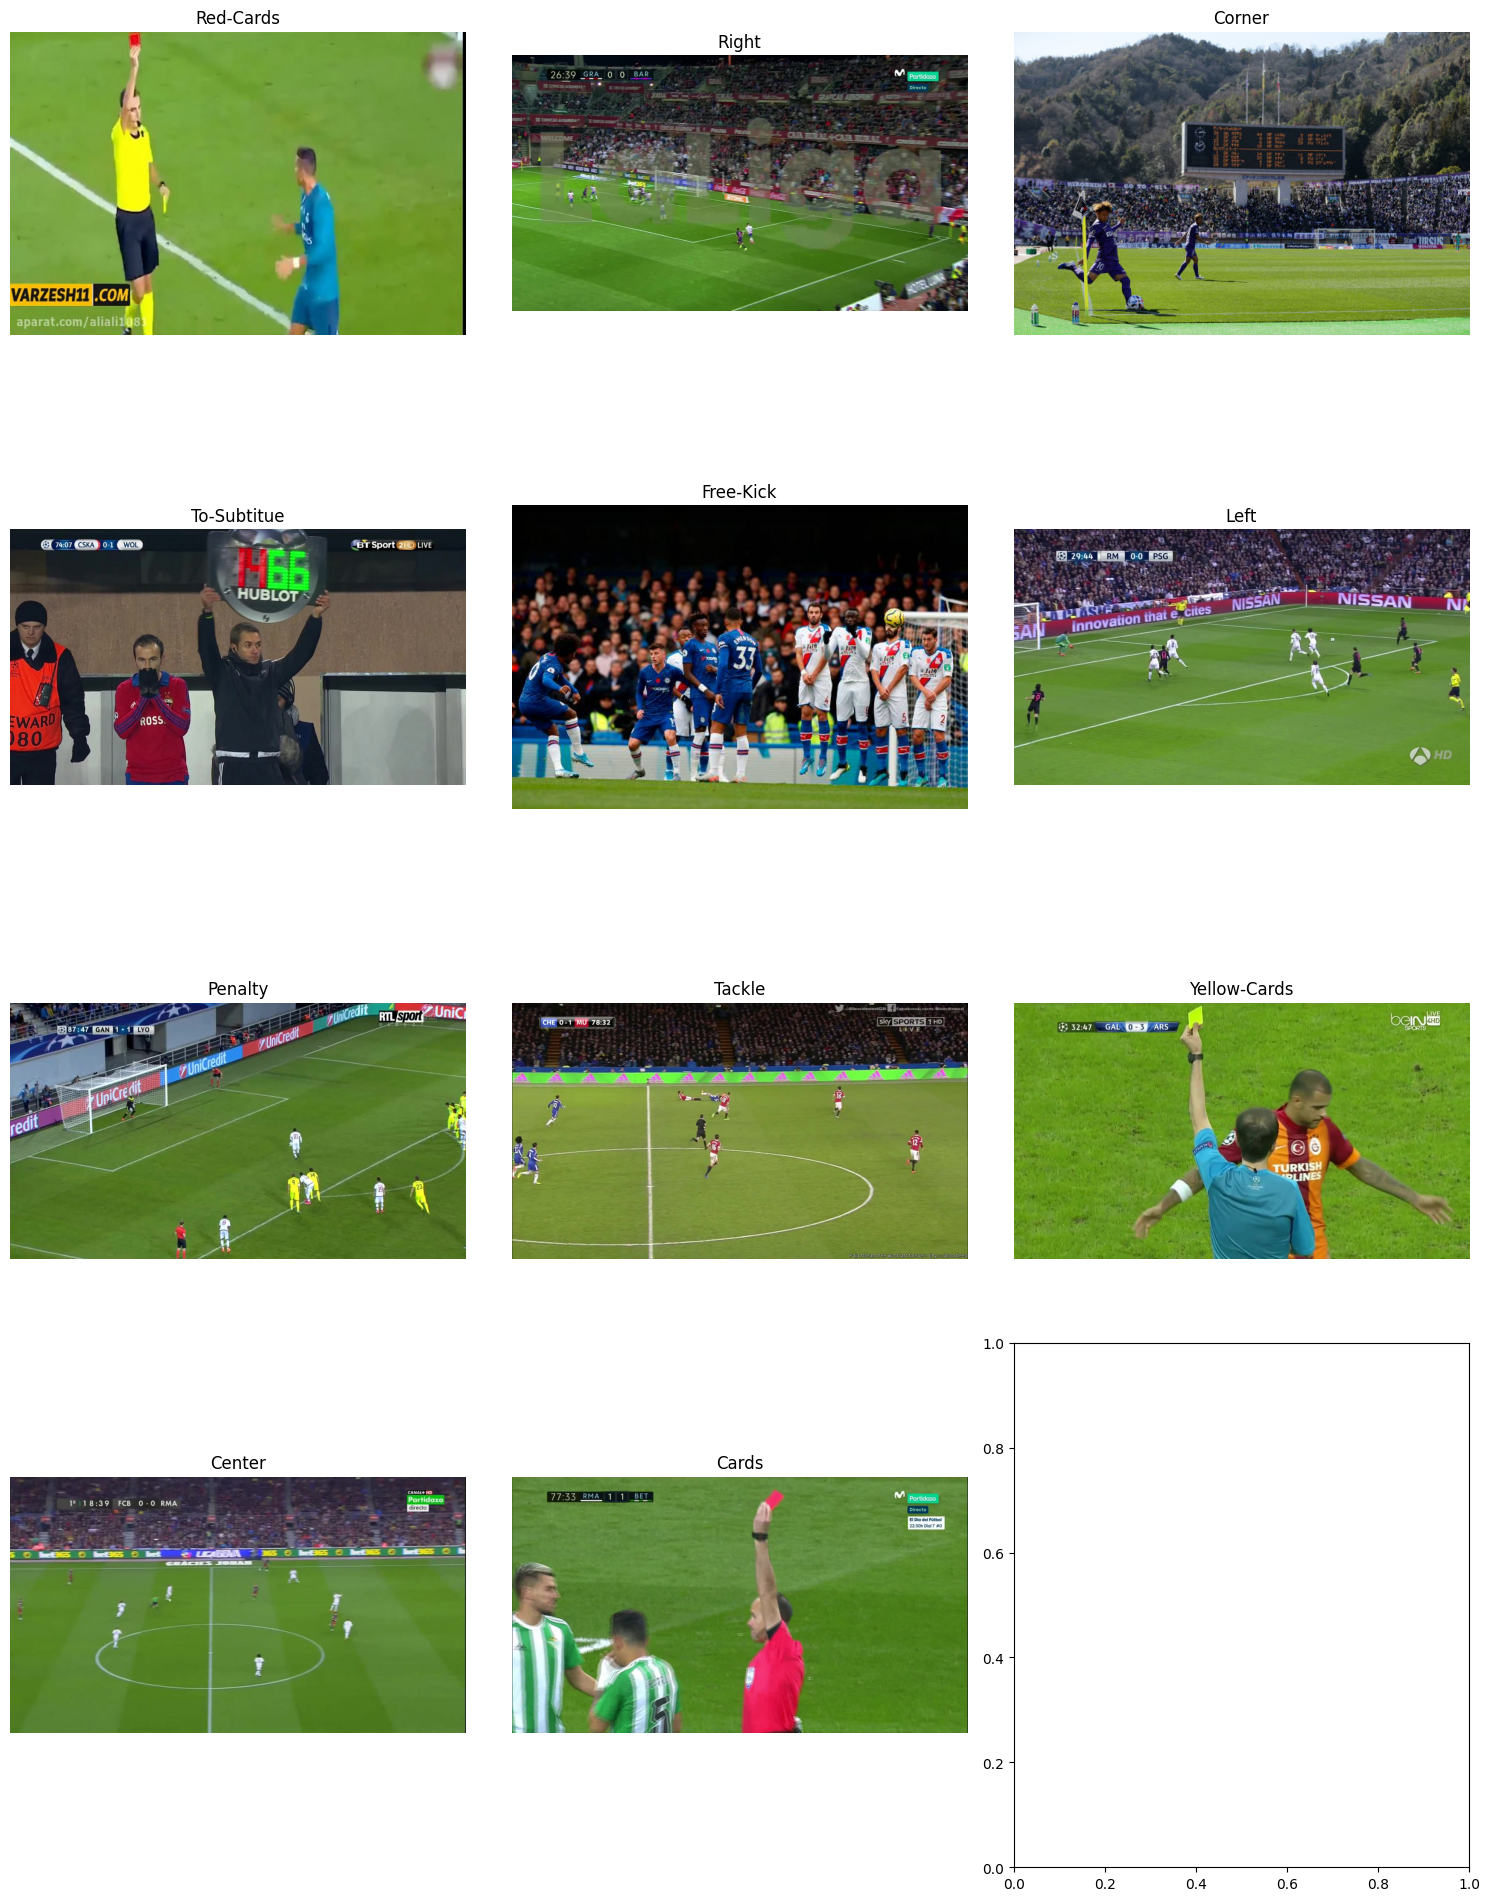

In [21]:
# Plot images from train folder
plot_images_from_folder(test_folder_extraction)

# Tensor Generation


## Create Training and Validation Tensors

In [22]:
train_img, train_lbl = resize_images(category_names, train_folder_extraction, size=5500)

Listing files in directory for category Cards.
Listing files in directory for category Center.
Listing files in directory for category Corner.
Listing files in directory for category Free-Kick.
Listing files in directory for category Left.
Listing files in directory for category Penalty.
Listing files in directory for category Red-Cards.
Listing files in directory for category Right.
Listing files in directory for category Tackle.
Listing files in directory for category To-Subtitue.
Listing files in directory for category Yellow-Cards.
Processing complete.


In [23]:
# Replace 'your_folder_path' with the actual path of the folder you want to remove
#remove_folder(train_folder_extraction)

In [24]:
# Define the batch size to be used
batch_size = 32

In [25]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_img,
                                                  train_lbl,
                                                  test_size=0.09,
                                                  random_state=42)

In [26]:
# Convert your training data to TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((np.array(X_train), np.array(y_train)))

In [27]:
# Apply preprocessing to the training dataset
train_dataset = train_dataset.map(preprocess_image)

In [28]:
# Create ImageDataGenerator for training data
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255
)

# Flow training images in batches using the training generator
train_generator = train_datagen.flow(np.array(X_train), np.array(y_train), batch_size=batch_size)

In [29]:
# Create ImageDataGenerator for validation data
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


# Flow validation images in batches using the validation generator
val_generator = val_datagen.flow(np.array(X_val), np.array(y_val), batch_size=batch_size)

## Create Testing Tensors

In [30]:
test_img, test_lbl = resize_images(category_names, test_folder_extraction, size=500)

Listing files in directory for category Cards.
Listing files in directory for category Center.
Listing files in directory for category Corner.
Listing files in directory for category Free-Kick.
Listing files in directory for category Left.
Listing files in directory for category Penalty.
Listing files in directory for category Red-Cards.
Listing files in directory for category Right.
Listing files in directory for category Tackle.
Listing files in directory for category To-Subtitue.
Listing files in directory for category Yellow-Cards.
Processing complete.


In [31]:
# Convert your test data to TensorFlow Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((np.array(test_img), np.array(test_lbl)))

# Apply preprocessing to the test dataset
test_dataset = test_dataset.map(preprocess_image)

# Create ImageDataGenerator for test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow test images in batches using the test generator
test_generator = val_datagen.flow(np.array(test_img), np.array(test_lbl), batch_size=batch_size)

# Data Visualization

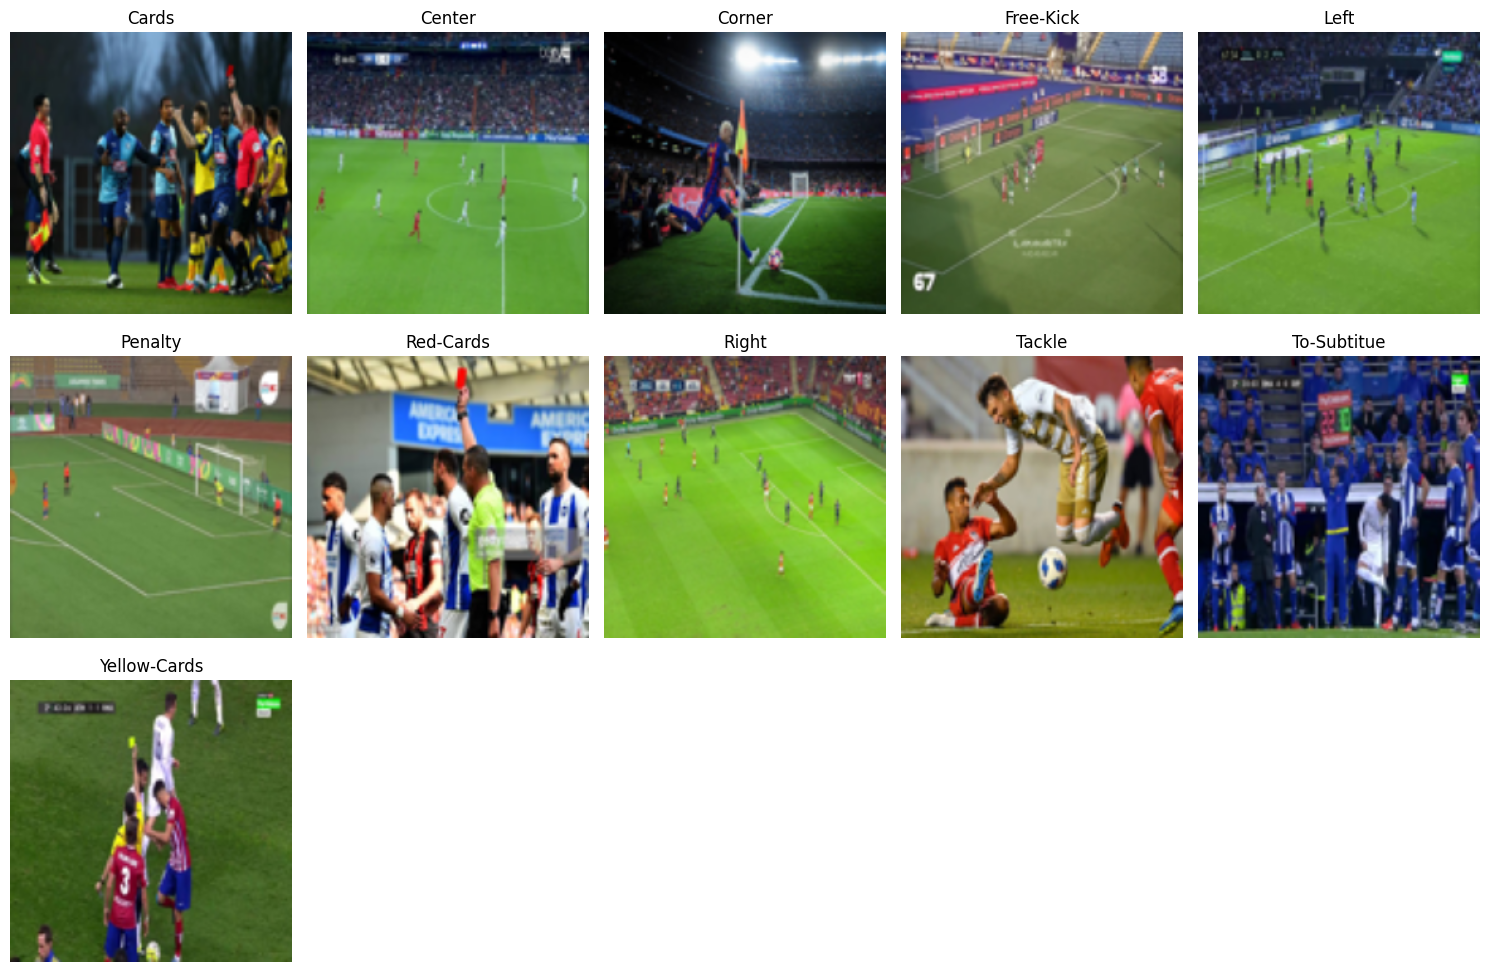

In [32]:
# Function to get a sample image for a given category
def get_sample_image_plot(images, target_size=(224, 224)):
    if images:
        sample_image = images[0]
        return tf.image.resize(sample_image, target_size)
    else:
        return None

# Set the number of rows and columns for subplots
num_rows = 3
num_cols = 5

# Set the figure size
plt.figure(figsize=(15, 10))

# Iterate through categories
for i, category in enumerate(category_names):
    category_images = [img for img, label in zip(X_train, y_train) if label == i]

    # Check if there are any images in the category
    if category_images:
        sample_image = get_sample_image_plot(category_images)  # Get the first image in the category

        # Plot the image
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(sample_image / 255.0)
        plt.title(category)
        plt.axis('off')
    else:
        print(f"No images found for category {category}")

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

# 1st CNN Model

In [ ]:
num_classes = len(category_names)
input_shape = (120, 120, 3)

In [ ]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

## Model

In [ ]:
model_1 = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_1.compile(optimizer='RMSprop',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

model_1.summary()

plot_model(model_1, show_shapes=True, show_layer_names=True)

In [ ]:
# Compile and train the CNN
history_1 = model_1.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

## Plots 1st CNN

In [ ]:
# Plot training & validation loss values
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss on First CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy on First CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix 1st CNN

In [ ]:
# Predictions
predictions_1 = model_1.predict(test_generator)
predicted_labels_1 = np.argmax(predictions_1, axis=1)[:len(y_val)]

# Convert y_val to a NumPy array
true_labels = np.array(y_val)

# If y_val has more than one dimension, use np.argmax to get the class labels
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Evaluation metrics
conf_matrix_1 = confusion_matrix(true_labels, predicted_labels_1)
accuracy_1 = accuracy_score(true_labels, predicted_labels_1)
f1_1 = f1_score(true_labels, predicted_labels_1, average='weighted')
recall_1 = recall_score(true_labels, predicted_labels_1, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy_1:.4f}")
print(f"F1 Score: {f1_1:.4f}")
print(f"Recall Score: {recall_1:.4f}")

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix on 1st CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# 2nd CNN Model

## Model

In [ ]:
model_2 = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Adjust the number of units based on the number of categories
])

# Compile the model
model_2.compile(optimizer='RMSprop', # RMSprop, SGD, adam
                loss='sparse_categorical_crossentropy',  # Adjust the loss function based on your problem
                metrics=['accuracy'])

# Display the model summary
model_2.summary()

plot_model(model_2, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history_2 = model_2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

## Plots 2nd CNN

In [ ]:
# Plot training & validation loss values
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss on Second CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model Accuracy on Second CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix 2nd CNN

In [ ]:
# Predictions
predictions_2 = model_2.predict(test_generator)
predicted_labels_2 = np.argmax(predictions_2, axis=1)[:len(y_val)]

# Convert y_val to a NumPy array
true_labels = np.array(y_val)

# If y_val has more than one dimension, use np.argmax to get the class labels
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Evaluation metrics
conf_matrix_2 = confusion_matrix(true_labels, predicted_labels_2)
accuracy_2 = accuracy_score(true_labels, predicted_labels_2)
f1_2 = f1_score(true_labels, predicted_labels_2, average='weighted')
recall_2 = recall_score(true_labels, predicted_labels_2, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy_2:.4f}")
print(f"F1 Score: {f1_2:.4f}")
print(f"Recall Score: {recall_2:.4f}")

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_2, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix on 2nd CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# 3rd CNN Model

## Model

In [ ]:
model_3 = models.Sequential([
    layers.Conv2D(64, (3, 3), strides=(2, 2), activation='relu', input_shape=(120, 120, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model_3.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.summary()

plot_model(model_3, show_shapes=True, show_layer_names=True)

In [ ]:
# Train the model
history_3 = model_3.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

## Plots 3rd CNN

In [ ]:
# Plot training & validation loss values
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model loss on Third CNN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy on Third CNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion Matrix 3rd CNN

In [ ]:
# Predictions
predictions_3 = model_3.predict(test_generator)
predicted_labels_3 = np.argmax(predictions_3, axis=1)[:len(y_val)]

# Convert y_val to a NumPy array
true_labels = np.array(y_val)

# If y_val has more than one dimension, use np.argmax to get the class labels
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Evaluation metrics
conf_matrix_3 = confusion_matrix(true_labels, predicted_labels_3)
accuracy_3 = accuracy_score(true_labels, predicted_labels_3)
f1_3 = f1_score(true_labels, predicted_labels_3, average='weighted')
recall_3 = recall_score(true_labels, predicted_labels_3, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy_3:.4f}")
print(f"F1 Score: {f1_3:.4f}")
print(f"Recall Score: {recall_3:.4f}")

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_3, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix on 3rd CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# MobileNetV2 CNN

In [ ]:
# Create MobileNetV2 base model
base_model_mbnv2 = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze pre-trained layers
for layer in base_model_mbnv2.layers:
    layer.trainable = False

# Build the custom model on top
model_mbnv2 = models.Sequential([
    base_model_mbnv2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_mbnv2.compile(optimizer='RMSprop',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Display model summary
model_mbnv2.summary()

In [ ]:
# Train the model
history_mbnv2 = model_mbnv2.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

## Plots MobileNetV2 CNN

In [ ]:
# Plot training & validation loss values
plt.plot(history_mbnv2.history['loss'], label='Train')
plt.plot(history_mbnv2.history['val_loss'], label='Validation')
plt.title('Model loss on MobileNetV2 CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_mbnv2.history['accuracy'], label='Train')
plt.plot(history_mbnv2.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy on MobileNetV2 CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix MobileNetV2 CNN

In [ ]:
# Predictions
predictions_mbnv2 = model_mbnv2.predict(test_generator)
predicted_labels_mbnv2 = np.argmax(predictions_mbnv2, axis=1)[:len(y_val)]

# Convert y_val to a NumPy array
true_labels = np.array(y_val)

# If y_val has more than one dimension, use np.argmax to get the class labels
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Evaluation metrics
conf_matrix_mbnv2 = confusion_matrix(true_labels, predicted_labels_mbnv2)
accuracy_mbnv2 = accuracy_score(true_labels, predicted_labels_mbnv2)
f1_mbnv2 = f1_score(true_labels, predicted_labels_mbnv2, average='weighted')
recall_mbnv2 = recall_score(true_labels, predicted_labels_mbnv2, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy_mbnv2:.4f}")
print(f"F1 Score: {f1_mbnv2:.4f}")
print(f"Recall Score: {recall_mbnv2:.4f}")

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_mbnv2, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix on MobileNetV2 CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Model EfficientNet

In [ ]:
# Create EfficientNetB0 base model
base_model_effnet = EfficientNetB0(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze pre-trained layers
for layer in base_model_effnet.layers:
    layer.trainable = False

# Build the custom model on top
model_effnet = models.Sequential([
    base_model_effnet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_effnet.compile(optimizer='RMSprop',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Display model summary
model_effnet.summary()

In [ ]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_val_one_hot = to_categorical(y_val, num_classes=num_classes)

# Train the model
history_effnet = model_effnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
)

## Plots EfficientNet CNN

In [ ]:
# Plot training & validation loss values
plt.plot(history_effnet.history['loss'], label='Train')
plt.plot(history_effnet.history['val_loss'], label='Validation')
plt.title('Model loss on EfficientNet CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Plot training & validation accuracy values
plt.plot(history_effnet.history['accuracy'], label='Train')
plt.plot(history_effnet.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy on EfficientNet CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix EfficientNet CNN

In [ ]:
# Predictions
predictions_effnet = model_effnet.predict(test_generator)
predicted_labels_effnet = np.argmax(predictions_effnet, axis=1)[:len(y_val)]

# Convert y_val to a NumPy array
true_labels = np.array(y_val)

# If y_val has more than one dimension, use np.argmax to get the class labels
if true_labels.ndim > 1:
    true_labels = np.argmax(true_labels, axis=1)

# Evaluation metrics
conf_matrix_effnet = confusion_matrix(true_labels, predicted_labels_effnet)
accuracy_effnet = accuracy_score(true_labels, predicted_labels_effnet)
f1_effnet = f1_score(true_labels, predicted_labels_effnet, average='weighted')
recall_effnet = recall_score(true_labels, predicted_labels_effnet, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy_effnet:.4f}")
print(f"F1 Score: {f1_effnet:.4f}")
print(f"Recall Score: {recall_effnet:.4f}")

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_effnet, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix on EfficientNet CNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
tf.keras.backend.clear_session()

# Evaluation on Soccer and Event images

In [ ]:
'''
print("---Extracting soccer---")
extract_all_zips(soccer_folder_path, soccer_folder_extraction)
print("Process completed")
print("---Extracting event---")
extract_all_zips(event_folder_path, event_folder_extraction)
print("Process completed")
'''

# End

In [ ]:
end_time = time.time()

In [ ]:
execution_time = (end_time - start_time)/60

print(f"Execution time: {execution_time} minutes")